In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
from llama_latent_model import LatentLLaMA_SingleToken
from dataset import BarLinkageDataset 
import matplotlib.pyplot as plt
torch.set_float32_matmul_precision('medium')
from sklearn.neighbors import NearestNeighbors

from dataset_generation.curve_plot import get_pca_inclination, rotate_curve
import scipy.spatial.distance as sciDist
from tqdm import tqdm
import requests
import time
import matplotlib.pyplot as plt
import os
import json
import torch.nn.functional as F

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [ ]:
# Headless simulator version
index = 0 # local server index 
API_ENDPOINT = f"http://localhost:4000/simulation"
HEADERS = {"Content-Type": "application/json"}
speedscale = 1
steps = 360
minsteps = int(steps*20/360)

In [ ]:
checkpoint_path = "./weights/CE_GAUS/LATENT_LLAMA_d768_h8_n6_bs512_lr0.0005_best.pth"
data_dir = "/home/anurizada/Documents/processed_dataset_17"
batch_size = 1

dataset = BarLinkageDataset(data_dir=data_dir)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [ ]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model_config = checkpoint['model_config']

# Initialize model
model = LatentLLaMA_SingleToken(
    tgt_seq_len=model_config['tgt_seq_len'],
    d_model=model_config['d_model'],
    h=model_config['h'],
    N=model_config['N'],
    num_labels=model_config['num_labels'],
    vocab_size=model_config['vocab_size'],
    latent_dim=model_config['latent_dim']).to(device)

# Load weights
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# ---------------------------
# Count parameters
# ---------------------------
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params

    print("\n🧮 Model Parameter Summary")
    print(f"Total parameters:     {total_params:,}  ({total_params/1e6:.2f} M)")
    print(f"Trainable parameters: {trainable_params:,}  ({trainable_params/1e6:.2f} M)")
    print(f"Frozen parameters:    {non_trainable_params:,}  ({non_trainable_params/1e6:.2f} M)")
    return total_params, trainable_params, non_trainable_params

# Run the counter
count_parameters(model)

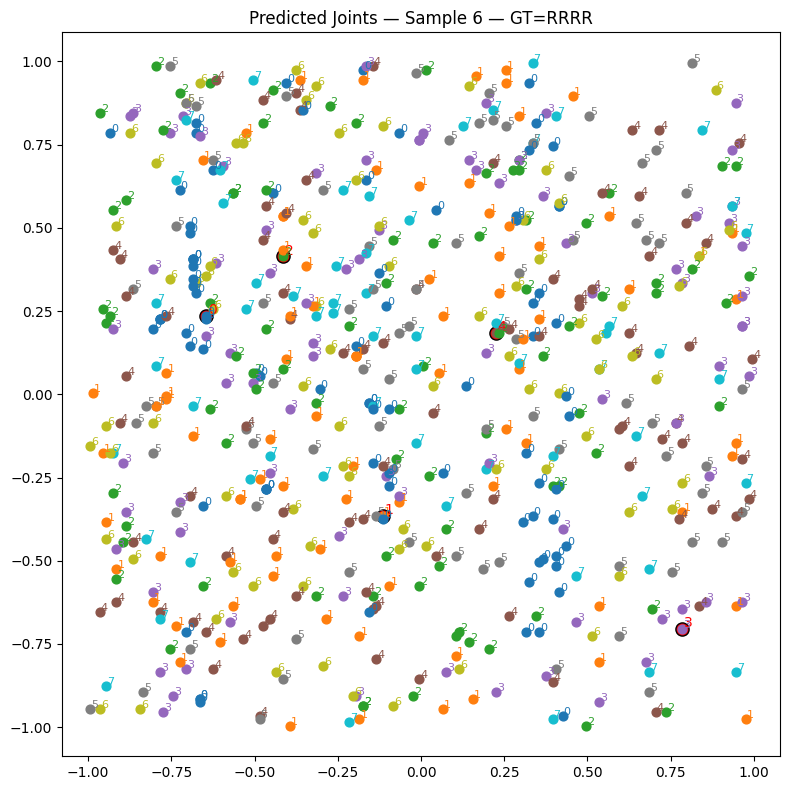

In [5]:
# =========================================================
# CONFIG
# =========================================================
MAX_SAMPLES = 100
SOS_TOKEN, EOS_TOKEN, PAD_TOKEN = 0, 1, 2
NUM_SPECIAL_TOKENS = 3
NUM_MECH_TYPES = 17
BIN_OFFSET = NUM_SPECIAL_TOKENS
NUM_BINS = 201
LATENT_DIM = 50   # must match training

label_mapping_path = "/home/anurizada/Documents/processed_dataset_17/label_mapping.json"
coupler_mapping_path = "/home/anurizada/Documents/transformer/BSIdict.json"

with open(label_mapping_path, "r") as f:
    label_mapping = json.load(f)
index_to_label = label_mapping["index_to_label"]

with open(coupler_mapping_path, "r") as f:
    coupler_mapping = json.load(f)


def coupler_index_for(mech_type: str) -> int:
    """Return coupler curve index from BSIdict.json."""
    if mech_type in coupler_mapping and "c" in coupler_mapping[mech_type]:
        cvec = coupler_mapping[mech_type]["c"]
        if isinstance(cvec, list) and 1 in cvec:
            return cvec.index(1)
    return -1


# ---------------------------------------------------------
# Helper: safe + short names for filesystem paths
# ---------------------------------------------------------
def safe_name(name: str, max_len: int = 30) -> str:
    chars = []
    for c in name:
        if c.isalnum():
            chars.append(c)
        else:
            chars.append("_")
    sanitized = "".join(chars)
    return sanitized[:max_len] or "unk"


def temp_to_str(t: float) -> str:
    s = f"{t:.2f}".rstrip("0").rstrip(".")
    s = s.replace(".", "p").replace("-", "m")
    return s or "0"


# =========================================================
# CoordinateBinner (matches training)
# =========================================================
class CoordinateBinner:
    def __init__(self, kappa=1.0, num_bins=200):
        self.kappa = kappa
        self.num_bins = num_bins
        self.bin_edges = np.linspace(-kappa, kappa, num_bins + 1)
        self.bin_centers = (self.bin_edges[:-1] + self.bin_edges[1:]) / 2

    def bin_to_value_torch(self, idx):
        idx = torch.clamp(idx, 0, self.num_bins - 1)
        centers = torch.tensor(self.bin_centers, device=idx.device, dtype=torch.float32)
        return centers[idx]


binner = CoordinateBinner(kappa=1.0, num_bins=NUM_BINS - 1)


# =========================================================
# Causal mask
# =========================================================
def build_causal_mask(seq_len, device):
    m = torch.tril(torch.ones(seq_len, seq_len, dtype=torch.bool, device=device))
    return m.unsqueeze(0).unsqueeze(0)


# =========================================================
# AUTOREGRESSIVE LATENT DECODING
# =========================================================
def predict_autoregressive_latent(
    model, latent, mech_idx, max_seq_len, device,
    temperature=1.0, top_k=None, eos_token=EOS_TOKEN, sos_token=SOS_TOKEN
):
    model.eval()

    if latent.dim() == 1:
        latent = latent.unsqueeze(0)

    latent = latent.to(device)
    mech_labels = torch.tensor([mech_idx], dtype=torch.long, device=device)

    decoder_input = torch.tensor([[sos_token]], dtype=torch.long, device=device)

    with torch.no_grad():
        for _ in range(max_seq_len):
            mask = build_causal_mask(decoder_input.size(1), device)
            logits = model(decoder_input, mask, latent, mech_labels)
            logits = logits[:, -1, :] / max(temperature, 1e-6)
            probs = F.softmax(logits, dim=-1)

            if top_k is not None:
                k = min(top_k, probs.size(-1))
                topk_probs, topk_idx = torch.topk(probs, k)
                next_token = topk_idx.gather(-1, torch.multinomial(topk_probs, 1))
            elif temperature == 0:
                next_token = torch.argmax(probs, dim=-1, keepdim=True)
            else:
                next_token = torch.multinomial(probs, 1)

            token = int(next_token.item())
            decoder_input = torch.cat([decoder_input, next_token], dim=1)
            if token == eos_token:
                break

    return decoder_input.squeeze(0).cpu().numpy()


# =========================================================
# MAIN
# =========================================================
tgt_seq_len = model_config["tgt_seq_len"]

print("Starting conditional coupler curve generation (latent-based)...")
os.makedirs("results_coupler_latent", exist_ok=True)

for i, batch in enumerate(tqdm(dataloader, total=min(MAX_SAMPLES, len(dataset)), desc="Simulating")):
    if i >= MAX_SAMPLES:
        break

    # ----------------------------------------------------
    # Latent
    # ----------------------------------------------------
    latents = batch["vae_mu"].to(device).squeeze(-1)
    latent = latents[0]

    # ----------------------------------------------------
    # Ground truth mechanism info
    # ----------------------------------------------------
    gt_tokens = batch["labels_discrete"][0].numpy()
    gt_mech_idx = int(batch["encoded_labels"][0].item())
    gt_mech_name = index_to_label[str(gt_mech_idx)]
    gt_mech_safe = safe_name(gt_mech_name)

    sample_dir = f"results_coupler_latent/sample_{i:03d}_{gt_mech_safe}"
    os.makedirs(sample_dir, exist_ok=True)

    # ----------------------------------------------------
    # Save input image
    # ----------------------------------------------------
    if "images" in batch:
        img_np = batch["images"][0].detach().cpu().squeeze().numpy()
        plt.imsave(os.path.join(sample_dir, "input_image.png"), img_np, cmap="gray")

    # ----------------------------------------------------
    # Decode ground truth joints
    # ----------------------------------------------------
    gt_coord_tokens = [t for t in gt_tokens if t >= BIN_OFFSET]
    if len(gt_coord_tokens) < 4:
        continue

    gt_coords = binner.bin_to_value_torch(
        torch.tensor(gt_coord_tokens, device=device) - BIN_OFFSET
    ).cpu().numpy()

    if gt_coords.size % 2:
        gt_coords = gt_coords[:-1]

    gt_points = gt_coords.reshape(-1, 2)

    # ----------------------------------------------------
    # Simulate ground truth coupler motion
    # ----------------------------------------------------
    sim_req = {
        "params": gt_points.tolist(),
        "type": gt_mech_name,
        "speedScale": speedscale,
        "steps": steps,
        "relativeTolerance": 0.1,
    }
    try:
        resp = requests.post(API_ENDPOINT, headers=HEADERS, data=json.dumps([sim_req])).json()
        P = np.array(resp[0]["poses"]) if isinstance(resp, list) and "poses" in resp[0] else None
    except:
        continue

    if P is None or P.shape[0] < minsteps:
        continue

    coup_idx = coupler_index_for(gt_mech_name)
    if coup_idx < 0:
        continue

    original_x = P[:, coup_idx, 0]
    original_y = P[:, coup_idx, 1]

    # Normalization parameters
    orig_phi = -get_pca_inclination(original_x, original_y)
    orig_denom = np.sqrt(np.var(original_x) + np.var(original_y)) + 1e-8
    ox_mean, oy_mean = np.mean(original_x), np.mean(original_y)

    # Store predictions
    all_predicted_points = {}

    # ============================================================
    # Loop: all mechanisms × temperatures
    # ============================================================
    temperatures = [0.0, 0.5, 1.0, 1.5, 2.0]

    for mech_idx in range(NUM_MECH_TYPES):
        mech_name = index_to_label[str(mech_idx)]
        mech_safe = safe_name(mech_name)

        for temp in temperatures:
            temp_str = temp_to_str(temp)

            # ----------------------------------------------------
            # Predict joints
            # ----------------------------------------------------
            pred_tokens = predict_autoregressive_latent(
                model, latent, mech_idx, tgt_seq_len,
                device, temperature=temp, top_k=None
            )
            coord_tokens = [t for t in pred_tokens if t >= BIN_OFFSET]
            if len(coord_tokens) < 4:
                continue

            coords_float = binner.bin_to_value_torch(
                torch.tensor(coord_tokens, device=device) - BIN_OFFSET
            ).cpu().numpy()

            if coords_float.size % 2 == 1:
                coords_float = coords_float[:-1]

            pred_points = coords_float.reshape(-1, 2)
            all_predicted_points[f"{mech_safe}_t{temp_str}"] = pred_points

            # ----------------------------------------------------
            # Simulate predicted mechanism
            # ----------------------------------------------------
            sim_req_pred = {
                "params": pred_points.tolist(),
                "type": mech_name,
                "speedScale": speedscale,
                "steps": steps,
                "relativeTolerance": 0.1,
            }
            try:
                resp_p = requests.post(API_ENDPOINT, headers=HEADERS, data=json.dumps([sim_req_pred])).json()
                Pp = np.array(resp_p[0]["poses"]) if isinstance(resp_p, list) and "poses" in resp_p[0] else None
            except:
                continue

            if Pp is None or Pp.shape[0] < minsteps:
                continue

            coup_idx_pred = coupler_index_for(mech_name)
            if coup_idx_pred < 0:
                continue

            gen_x = Pp[:, coup_idx_pred, 0]
            gen_y = Pp[:, coup_idx_pred, 1]

            # ----------------------------------------------------
            # Align predicted coupler to GT
            # ----------------------------------------------------
            gen_phi = -get_pca_inclination(gen_x, gen_y)
            rotation = gen_phi - orig_phi
            gen_x, gen_y = rotate_curve(gen_x, gen_y, rotation)

            gen_denom = np.sqrt(np.var(gen_x) + np.var(gen_y)) + 1e-8
            scale = orig_denom / gen_denom
            gen_x *= scale
            gen_y *= scale

            gen_x -= (np.mean(gen_x) - ox_mean)
            gen_y -= (np.mean(gen_y) - oy_mean)

            # ----------------------------------------------------
            # PLOT WITH **JOINT NUMBERING**
            # ----------------------------------------------------
            plt.figure(figsize=(6, 6))
            plt.plot(original_x, original_y, "r-", label=f"GT ({gt_mech_name})")
            plt.plot(gen_x, gen_y, "g--", label=f"Pred {mech_name} t={temp}")

            # GT joints (numbered)
            plt.scatter(gt_points[:, 0], gt_points[:, 1], c="red", s=50)
            for j, (xj, yj) in enumerate(gt_points):
                plt.text(xj + 0.003, yj + 0.003, f"{j}", fontsize=9, color="red")

            # Predicted joints (numbered)
            for j, (xp, yp) in enumerate(pred_points):
                plt.scatter(xp, yp, c="green", s=50)
                plt.text(xp + 0.003, yp + 0.003, f"{j}", fontsize=8, color="green")

            plt.axis("equal")
            plt.legend()
            plt.tight_layout()

            save_path = os.path.join(sample_dir, f"{mech_safe}_t{temp_str}.png")
            plt.savefig(save_path)
            plt.close()

    # ============================================================
    # FINAL: Combined joint scatter plot (numbered)
    # ============================================================
    if len(all_predicted_points) == 0:
        continue

    plt.figure(figsize=(8, 8))

    # GT numbered
    plt.scatter(gt_points[:, 0], gt_points[:, 1], c="red", s=90, edgecolor="black")
    for j, (x, y) in enumerate(gt_points):
        plt.text(x + 0.005, y + 0.005, f"{j}", color="red", fontsize=10)

    max_joints = max(pts.shape[0] for pts in all_predicted_points.values())
    cmap = plt.cm.get_cmap("tab10", max_joints)

    for mech_key, pts in all_predicted_points.items():
        for j in range(pts.shape[0]):
            color = cmap(j % max_joints)
            xj, yj = pts[j]
            plt.scatter(xj, yj, color=color, s=40)
            plt.text(xj + 0.003, yj + 0.003, f"{j}", fontsize=8, color=color)

    plt.axis("equal")
    plt.title(f"Predicted Joints — Sample {i} — GT={gt_mech_name}")
    plt.tight_layout()

    out_path = os.path.join(sample_dir, "all_predicted_joints_colored.png")
    plt.savefig(out_path, dpi=200)
    plt.close()

    print(f"Saved: {out_path}")

print("DONE.")
